# Scaling up

## Imports

In [2]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

from datetime import date
import torchvision
import numpy as np
import torch
import argparse
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim
import time
import copy
import torchvision.transforms as transforms
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/My Drive/drive_folder')
from custom_dataset_loader import TaiChiDataset, ToTensor, Normalize
from helper_functions import set_parameter_requires_grad, meshgrid2d, get_grid, plot_learning_curve, split_dataset, initialise_model, get_predictions, zero_out_coords, show_predictions


Mounted at /content/drive


## Helper functions

In [115]:
def show_predictions(pred_coords, pred_vis, true_coords, true_vis, zeroed=False, num_samples=3):
  batch_size = pred_coords.shape[0]

  # sample some samples at random
  sample_ids = np.random.choice(batch_size, num_samples)

  for x in sample_ids:
    pred_c = pred_coords[x, :, :, :].cpu().detach().numpy().squeeze()
    pred_v = pred_vis[x, :, :].cpu().detach().numpy().squeeze()
    true_c = true_coords[x, :, :, :].cpu().numpy().squeeze()
    true_v = true_vis[x, :, :].cpu().numpy().squeeze()
    
    pred_v = pred_v <= 0
    true_v = true_v <= 0
    
    # print(np.count_nonzero(true_vis))
    # print(np.count_nonzero(pred_vis))
    
    if zeroed:
      true_c[ :, 0] = np.where(true_v, 0, true_c[ :, 0])
      true_c[ :, 1] = np.where(true_v, 0, true_c[ :, 1])
      pred_c[ :, 0] = np.where(pred_v, 0, pred_c[ :, 0])
      pred_c[ :, 1] = np.where(pred_v, 0, pred_c[ :, 1])
      pred_v = true_v

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  
    ax1.scatter(true_c[:, 0], true_c[:, 1], s=0.5, marker='.', c=true_v, cmap=plt.cm.coolwarm)
    ax1.set_ylim(360, 0)
    ax1.set_title('True Coords')

    pred_x = pred_c[:, 0]
    pred_y = pred_c[:, 1]
    ax2.scatter(pred_x, pred_y, s=0.5, marker='.', c=pred_v, cmap=plt.cm.coolwarm)
    ax2.set_ylim(360, 0)
    ax2.set_title('Predicted Coords')
    
    plt.show()

In [132]:
from tabulate import tabulate
import math

def load_checkpoint(filename):
  filepath = "/content/drive/MyDrive/checkpoints/"+filename
  checkpoint = torch.load(filepath)

  t_loss = [x[1] for x in checkpoint['train_loss_history']]
  v_loss = [x[1] for x in checkpoint['val_loss_history']]

  points = np.linspace(0,checkpoint['epochs'],5, dtype=int)
  train_loss = ['train_loss']
  valid_loss = ['valid_loss']
  header = [checkpoint['description']]

  for p in points:
    header.append("E="+str(p))
    if p == points[-1]:
      p=p-1
    train_loss.append(t_loss[p])
    if v_loss:
      valid_loss.append(v_loss[math.ceil(p/100)])
    
  results = [header,
            train_loss,
            valid_loss]
           
  print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

  plot_learning_curve(checkpoint['train_loss_history'], checkpoint['val_loss_history'])

  return checkpoint['state_dict'], checkpoint['random_seed']

## Train function

In [116]:
def train_model(model, dataloaders, criterion, vis_criterion, optimizer, num_epochs=10_000, verbose=False, mask=True, clip=1.0, store_val=False, eval_freq=100, report_freq=500):
  model.to(device)
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 0.0

  # Log loss history
  train_loss_history = list()
  val_loss_history = list()

  train_size = len(dataloaders['train'].sampler.indices)
  valid_size = len(dataloaders['val'].sampler.indices)

  print("Starting training: {} epochs".format(num_epochs))
  print("Dataset size: Train-{}, Valid-{}".format(train_size, valid_size))
  # print("Batch sizes: Train-{}, Valid-{}".format(train_size/len(dataloaders['train']), valid_size/len(dataloaders['val'])))

  if valid_size==0:
    phases = ['train']
  else:
    phases = ['train', 'val']

  for epoch in range(0,num_epochs):
    # Each epoch has a training and validation phase (only do validation each 100th epoch)
    for phase in phases:
      if phase == 'train':
        model.train() # Set model to training mode
      elif phase == 'val' and (epoch%eval_freq==0 or epoch == num_epochs-1):
        model.eval() # Set model to evaluate mode
      else:
        continue
        
      running_loss = 0.0
      running_vis_loss = 0.0
      running_coords_loss = 0.0
      total_samples = 0

      # Iterate over data.
      for i_batch, sample_batched in enumerate(dataloaders[phase]):
        batch_size = len(sample_batched['id'])
        total_samples+=batch_size
              
        # Get input images and concatenate image tensors on channel dimension
        input1 = sample_batched['image0']
        input2 = sample_batched['image3']
        inputs = torch.cat((input1, input2), dim=1) 

        # Get ground truth coords and vis
        coords = sample_batched['coords']
        vis = torch.where(sample_batched['vis'] > 0, 1.0, 0.0)
              
        inputs = inputs.to(device).float() # torch.Size([B, 6, H, W])
        coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
        vis = vis.to(device) # torch.Size([B, 1, 4096])

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward and track history
        with torch.set_grad_enabled(phase == 'train'):

          # Get model outputs 
          outputs = model(inputs) # torch.Size([B, 3, H, W]) same as inputs shape
          outputs = outputs['out']
          outputs_coords, outputs_vis = get_predictions(outputs, coords, batch_size) # pre-processing of outputs

          # Zero out those in both outputs_coords and coords so they dont contribute to coords_loss
          outputs_coords_zeroed, coords_zeroed = zero_out_coords(coords, outputs_coords, vis)

          # Calculate loss
          sigmoid = nn.Sigmoid()
          vis_loss = (vis_criterion(sigmoid(outputs_vis), vis))/ 0.7
          if mask:
            coords_loss = (criterion(outputs_coords_zeroed, coords_zeroed))/20
          else:
            coords_loss = (criterion(outputs_coords, coords))/20
          loss = coords_loss + vis_loss
                    

          # Backward + optimize only in train phase
          if phase == 'train':
            loss.backward()

            # Gradient Norm/Value Clipping
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            nn.utils.clip_grad_value_(model.parameters(), clip_value=clip)

            optimizer.step()

          # Statistics
          running_loss += loss.item() * inputs.size(0)
          running_vis_loss += vis_loss.item() * inputs.size(0)
          running_coords_loss += coords_loss.item() * inputs.size(0)

      
      epoch_loss = running_loss/total_samples
      epoch_vis_loss = running_vis_loss/total_samples
      epoch_coords_loss = running_coords_loss/total_samples

      # Log losses to train/val loss history
      if phase == 'train':
        train_loss_history.append((epoch, epoch_loss, epoch_coords_loss, epoch_vis_loss))
      if phase == 'val':
        val_loss_history.append((epoch, epoch_loss, epoch_coords_loss, epoch_vis_loss))
        # Deep copy the best validation model
        if epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())

    # Report on losses of the model
    if verbose and epoch%report_freq==0:
      print('-' * 50)
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('Train Loss: {:.4f} ({:.4f} coords loss, {:.4f} vis loss) '.format(train_loss_history[-1][1], train_loss_history[-1][2], train_loss_history[-1][3]))
      if val_loss_history:                
        print('Valid Loss: {:.4f} ({:.4f} coords loss, {:.4f} vis loss) '.format(val_loss_history[-1][1], val_loss_history[-1][2], val_loss_history[-1][3])) 
      time_elapsed = time.time() - since
      print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

      if epoch !=0:
        # Plot recent learning curve
        plot_learning_curve(train_loss_history[-report_freq:], val_loss_history[-(report_freq//eval_freq+1):])
        # Show some random predictions from val mode
        show_predictions(outputs_coords, outputs_vis, coords, vis, zeroed=False, num_samples=1)
              
  time_elapsed = time.time() - since
  print('-' * 50)
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Final Train Loss: {:4f}\n'.format(train_loss_history[-1][1]))
  print('Best Valid Loss: {:4f}\n'.format(best_loss))
  print('-' * 50)

  # Storing best validation model weights or final training weights
  if store_val:
    model.load_state_dict(best_model_wts)
  else:
    final_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(final_model_wts)

  # Plot learning curve
  plot_learning_curve(train_loss_history, val_loss_history)

  # Show some final random predictions
  show_predictions(outputs_coords, outputs_vis, coords, vis, zeroed=True, num_samples=5)
  
  return model, train_loss_history, val_loss_history

In [127]:
def show_predictions_for_eval(pred_coords, pred_vis, true_coords, true_vis, img0, img7):
  batch_size = pred_coords.shape[0]

  # sample some samples at random
  sample_ids = np.arange(batch_size)

  for x in sample_ids:
    frame1 = img0[x, :, :, :]
    frame7 = img7[x, :, :, :]

    frame1 = img0[x, :, :, :].cpu().detach().squeeze()
    frame7 = img7[x, :, :, :].cpu().detach().squeeze()
    
    frame7=frame7.permute(1, 2, 0).numpy()
    frame1=frame1.permute(1, 2, 0).numpy()

    pred_c = pred_coords[x, :, :, :].cpu().detach().numpy().squeeze()
    pred_v = pred_vis[x, :, :].cpu().detach().numpy().squeeze()
    true_c = true_coords[x, :, :, :].cpu().numpy().squeeze()
    true_v = true_vis[x, :, :].cpu().numpy().squeeze()
    
    pred_v = pred_v <= 0
    true_v = true_v <= 0
    

    true_c[ :, 0] = np.where(true_v, 0, true_c[ :, 0])
    true_c[ :, 1] = np.where(true_v, 0, true_c[ :, 1])
    pred_c[ :, 0] = np.where(pred_v, 0, pred_c[ :, 0])
    pred_c[ :, 1] = np.where(pred_v, 0, pred_c[ :, 1])
    pred_v = true_v

    fig, ((ax3, ax4), (ax1, ax2)) = plt.subplots(2, 2, figsize=(12, 8))

    ax3.imshow(frame1)
    ax3.set_title('First frame')
    ax4.imshow(frame7)
    ax4.set_title('Last frame')
  
    ax1.scatter(true_c[:, 0], true_c[:, 1], s=0.5, marker='.', c=true_v, cmap=plt.cm.coolwarm)
    ax1.set_ylim(360, 0)
    ax1.set_title('True Coords')

    pred_x = pred_c[:, 0]
    pred_y = pred_c[:, 1]
    ax2.scatter(pred_x, pred_y, s=0.5, marker='.', c=pred_v, cmap=plt.cm.coolwarm)
    ax2.set_ylim(360, 0)
    ax2.set_title('Predicted Coords')
    
    plt.show()

In [123]:
def evaluate_model(model, valid_dataloader, criterion, vis_criterion):
  model.to(device)
  model.eval()
  
  # since = time.time()

  val_loss_history = list()
  valid_size = len(valid_dataloader.sampler.indices)

  running_loss = 0.0
  running_vis_loss = 0.0
  running_coords_loss = 0.0
  total_samples = 0

  # Iterate over data.
  for i_batch, sample_batched in enumerate(valid_dataloader):
    batch_size = len(sample_batched['id'])
    total_samples+=batch_size
              
    # Get input images and concatenate image tensors on channel dimension
    input1 = sample_batched['image0']
    input2 = sample_batched['image3']
    inputs = torch.cat((input1, input2), dim=1) 

    # Get ground truth coords and vis
    coords = sample_batched['coords']
    vis = torch.where(sample_batched['vis'] > 0, 1.0, 0.0)
              
    inputs = inputs.to(device).float() # torch.Size([B, 6, H, W])
    coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
    vis = vis.to(device) # torch.Size([B, 1, 4096])
  
    with torch.no_grad():
          # Get model outputs 
          outputs = model(inputs) # torch.Size([B, 3, H, W]) same as inputs shape
          outputs = outputs['out']
          outputs_coords, outputs_vis = get_predictions(outputs, coords, batch_size) # pre-processing of outputs

          # Zero out those in both outputs_coords and coords so they dont contribute to coords_loss
          outputs_coords_zeroed, coords_zeroed = zero_out_coords(coords, outputs_coords, vis)

          # Calculate loss
          sigmoid = nn.Sigmoid()
          vis_loss = (vis_criterion(sigmoid(outputs_vis), vis))/ 0.7
          coords_loss = (criterion(outputs_coords_zeroed, coords_zeroed))/20
          loss = coords_loss + vis_loss
                    
          # Statistics
          running_loss += loss.item() * inputs.size(0)
          running_vis_loss += vis_loss.item() * inputs.size(0)
          running_coords_loss += coords_loss.item() * inputs.size(0)

    show_predictions_for_eval(outputs_coords, outputs_vis, coords, vis, input1, sample_batched['image7'])
    print('Valid Loss: {:.4f} ({:.4f} coords loss, {:.4f} vis loss) '.format(loss.item(), coords_loss.item(), vis_loss.item()))

  epoch_loss = running_loss/total_samples
  epoch_vis_loss = running_vis_loss/total_samples
  epoch_coords_loss = running_coords_loss/total_samples

  print('Average valid Loss: {:.4f} ({:.4f} coords loss, {:.4f} vis loss) '.format(epoch_loss, epoch_coords_loss, epoch_vis_loss)) 

    
              

## Overfitting on 10 samples from 1 video

### Loading dataset

In [ ]:
# Load dataset
TRAIN_DATA = "same_video_10_frames_2023-02-12"
!unzip -d "$TRAIN_DATA"/ /content/drive/MyDrive/"$TRAIN_DATA".zip # unziping training data

dataset = TaiChiDataset(log_file=TRAIN_DATA+'/sample_ids.txt',
                        root_dir=TRAIN_DATA,
                        check=True,
                        transform=transforms.Compose([
                                               ToTensor(),
                                               Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                        ]))
print(len(dataset))

### Training

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

Starting training: 5000 epochs
Dataset size: Train-11, Valid-0
Batch sizes: Train-11.0, Valid-0
--------------------------------------------------
Epoch 0/4999
Train Loss: 6.0934 (5.1739 coords loss, 0.9196 vis loss) 
Time elapsed: 0m 9s
--------------------------------------------------
Epoch 500/4999
Train Loss: 0.2970 (0.2301 coords loss, 0.0669 vis loss) 
Time elapsed: 9m 44s


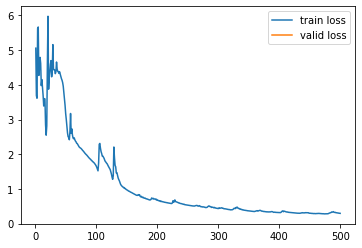

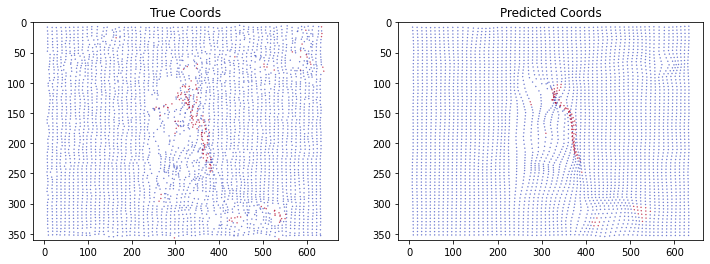

--------------------------------------------------
Epoch 1000/4999
Train Loss: 0.2443 (0.1969 coords loss, 0.0474 vis loss) 
Time elapsed: 19m 16s


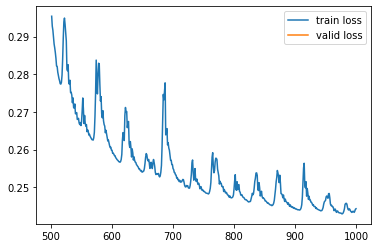

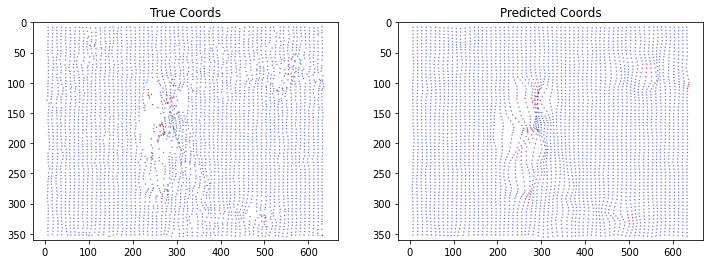

--------------------------------------------------
Epoch 1500/4999
Train Loss: 0.2394 (0.1942 coords loss, 0.0451 vis loss) 
Time elapsed: 28m 49s


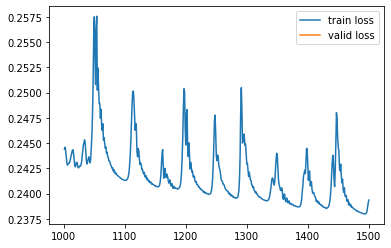

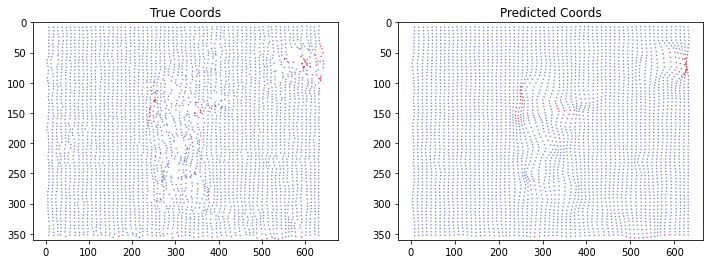

--------------------------------------------------
Epoch 2000/4999
Train Loss: 0.2371 (0.1939 coords loss, 0.0432 vis loss) 
Time elapsed: 38m 22s


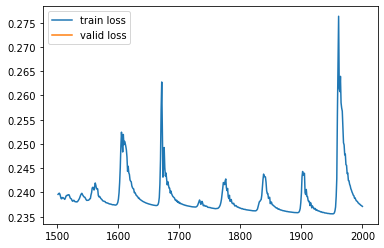

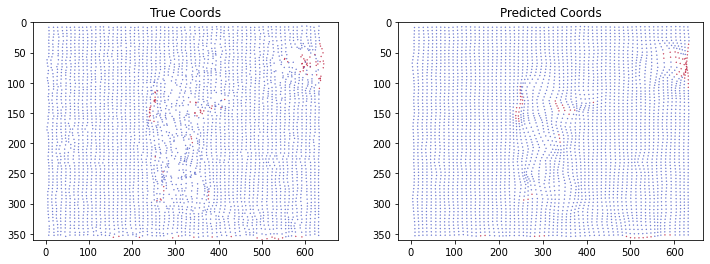

--------------------------------------------------
Epoch 2500/4999
Train Loss: 0.2340 (0.1924 coords loss, 0.0416 vis loss) 
Time elapsed: 47m 55s


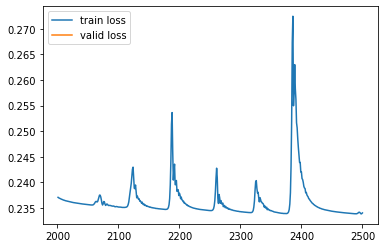

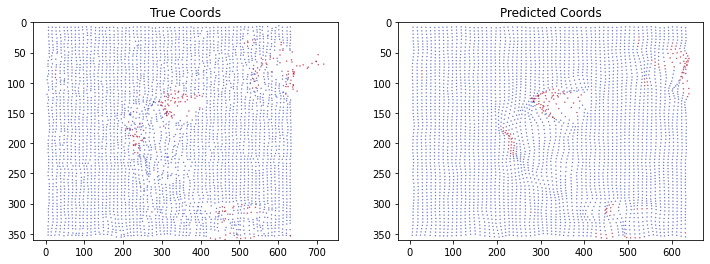

--------------------------------------------------
Epoch 3000/4999
Train Loss: 0.2323 (0.1915 coords loss, 0.0408 vis loss) 
Time elapsed: 57m 27s


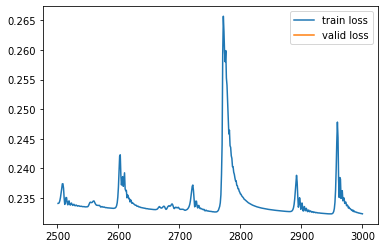

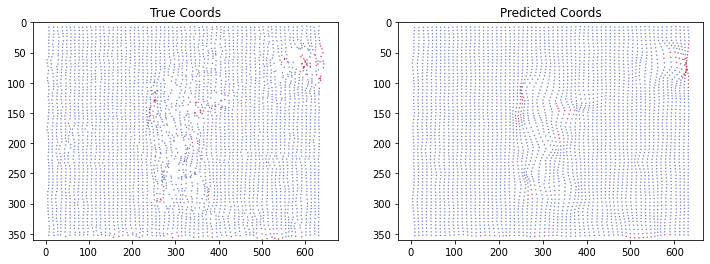

--------------------------------------------------
Epoch 3500/4999
Train Loss: 0.2394 (0.1966 coords loss, 0.0428 vis loss) 
Time elapsed: 66m 59s


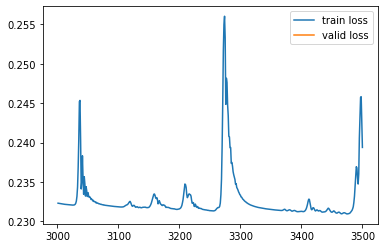

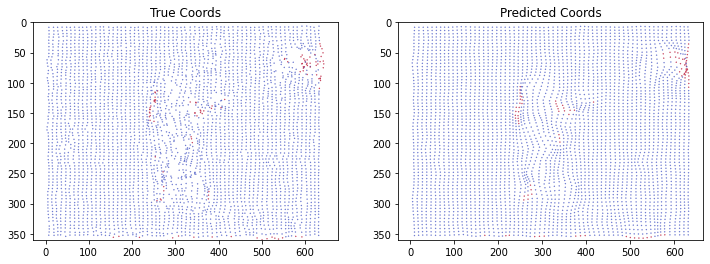

--------------------------------------------------
Epoch 4000/4999
Train Loss: 0.2299 (0.1902 coords loss, 0.0397 vis loss) 
Time elapsed: 76m 31s


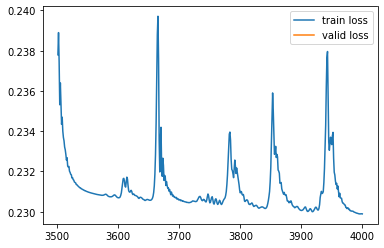

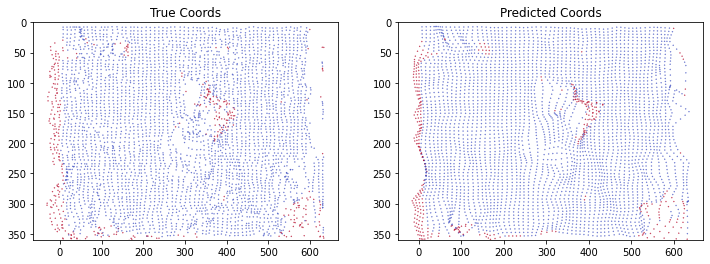

--------------------------------------------------
Epoch 4500/4999
Train Loss: 0.2329 (0.1927 coords loss, 0.0401 vis loss) 
Time elapsed: 86m 3s


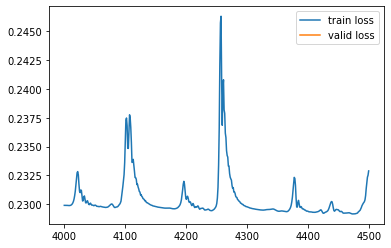

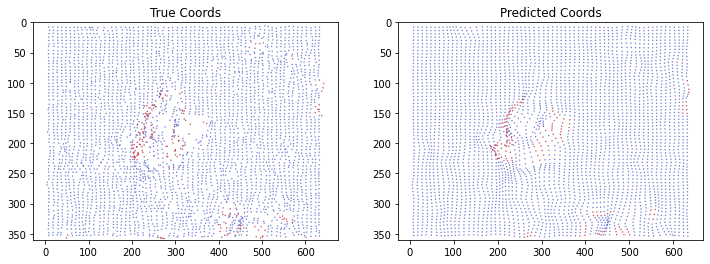

--------------------------------------------------
Training complete in 95m 34s
Final Train Loss: 0.234148

Best Valid Loss: 0.000000

--------------------------------------------------


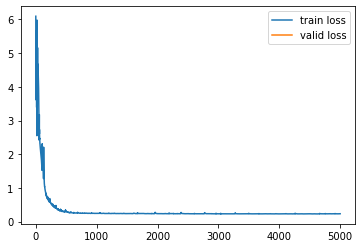

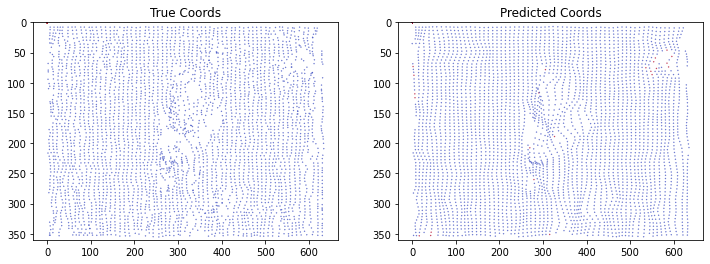

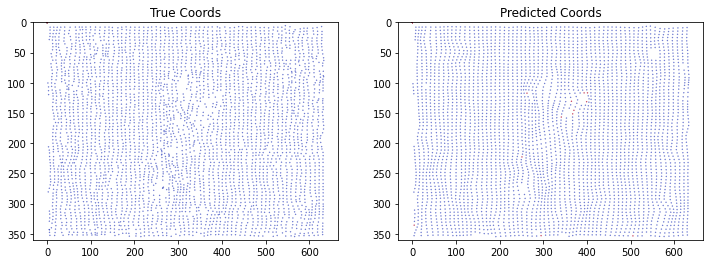

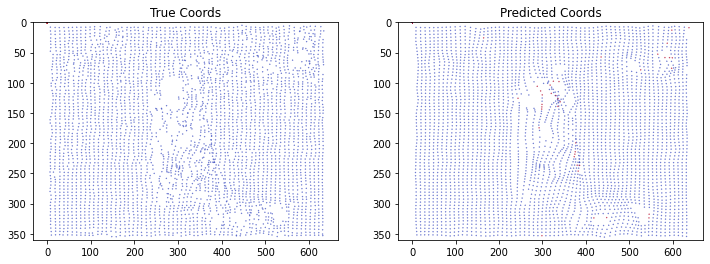

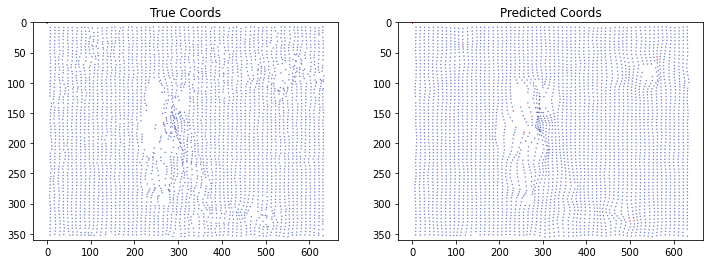

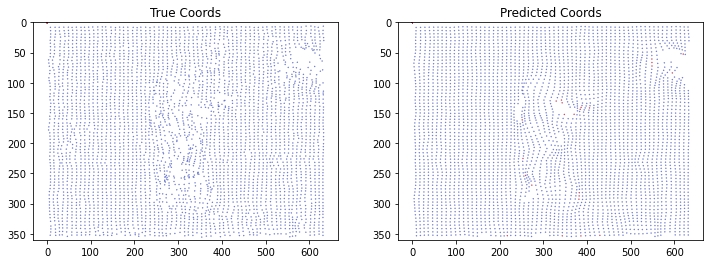

In [12]:
# Set computation device
device = torch.device('cuda')

# MODEL INITIALISATION
# possible params to_learn=[]:
#   'backbone.conv1.weight' - first layer
#   'backbone.layer1.0.conv1.weight' - second layer
#   'classifier.4.weight', 'classifier.4.bias' - last layer
#   'all' - all layers
modified_model = initialise_model(device, to_learn=['all'])
params_to_update = modified_model.parameters()

# print('Params to learn:')
# for name, param in modified_model.named_parameters():
#   if param.requires_grad:
#       print(name)

# DEFINE HYPERPARAMETERS
validation_split = 0.0 # Validation ratio split
shuffle_dataset = True
random_seed = 42
B = len(dataset) # Batch size
E = 5_000 # Number of epoch
C=1.0 # Gradient lip value
eval_freq=100 # Run val mode every 100th epoch
report_freq=500 #Print stats every 500th epoch

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, B, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Define optimizer
LR = 0.101 # learning rate
M = 0.9 # momentum
my_optimizer = optim.SGD(params_to_update, lr=LR, momentum=M)

# Setup the loss
my_criterion = nn.MSELoss()
my_vis_criterion = nn.BCELoss()

# TRAIN
model, model_t_loss,  model_v_loss  = train_model(modified_model,
                                                  dataloaders_dict,
                                                  my_criterion,
                                                  my_vis_criterion,
                                                  my_optimizer,
                                                  num_epochs=E,
                                                  verbose=True,
                                                  clip=C,
                                                  store_val=False, #store best val or train loss model
                                                  eval_freq=100,
                                                  report_freq=500)

### Save model

In [ ]:
# Save checkpoint
checkpoint = {'criterions': [my_criterion, my_vis_criterion],
              'description': 'model trained on 10 samples from the same video',
              'epochs': E,
              'train_loss_history': model_t_loss,
              'val_loss_history': model_v_loss,
              'params_to_learn': ["all"],
              'val_split': validation_split,
              'random_seed': random_seed,
              'batch_size': B,
              'optimizer': 'SGD',
              'learning_rate': LR,
              'momentum': M,
              'state_dict': model.state_dict()}


TODAY = date.today()
torch.save(checkpoint, 'checkpoint1'+str(TODAY)+'.pth')

# cp checkpoint into drive
!cp checkpoint1"$TODAY".pth /content/drive/MyDrive/checkpoints/

## Overfitting on 10 samples from 3 videos

### Loading dataset

In [126]:
# Load dataset
TRAIN_DATA = "three_videos_18_frames_2023-02-13"
!unzip -d "$TRAIN_DATA"/ /content/drive/MyDrive/"$TRAIN_DATA".zip # unziping training data

dataset = TaiChiDataset(log_file=TRAIN_DATA+'/sample_ids.txt',
                        root_dir=TRAIN_DATA,
                        check=True,
                        transform=transforms.Compose([
                                              ToTensor()
                        ]))
print(len(dataset))

Archive:  /content/drive/MyDrive/three_videos_18_frames_2023-02-13.zip
replace three_videos_18_frames_2023-02-13/frame7/-CR4xjdQbkc_824.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
18


### Training

Starting training: 1000 epochs
Dataset size: Train-15, Valid-3
--------------------------------------------------
Epoch 0/999
Train Loss: 4.8504 (4.1135 coords loss, 0.7370 vis loss) 
Valid Loss: 4.3980 (3.8044 coords loss, 0.5936 vis loss) 
Time elapsed: 0m 3s
--------------------------------------------------
Epoch 500/999
Train Loss: 0.4068 (0.3109 coords loss, 0.0959 vis loss) 
Valid Loss: 10.5326 (9.8155 coords loss, 0.7171 vis loss) 
Time elapsed: 25m 43s


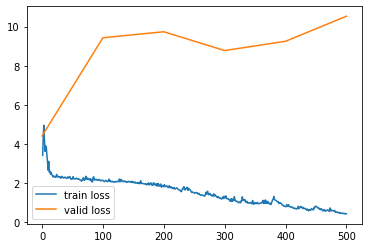

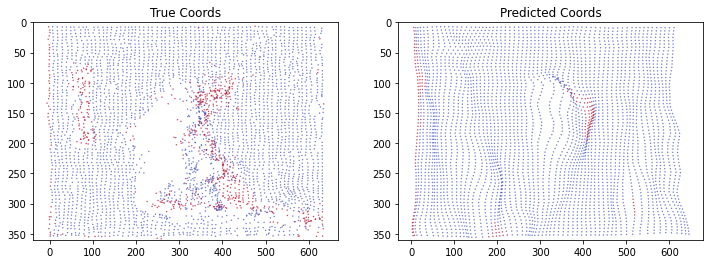

--------------------------------------------------
Training complete in 51m 30s
Final Train Loss: 0.138857

Best Valid Loss: 0.000000

--------------------------------------------------


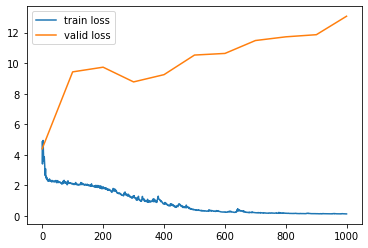

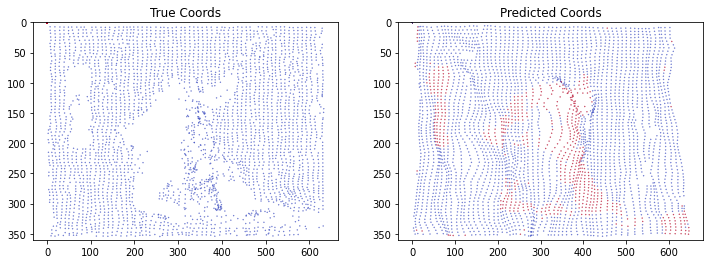

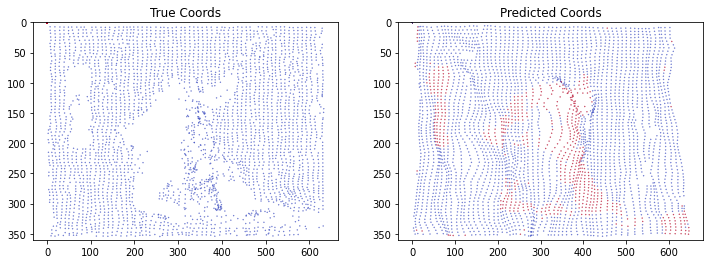

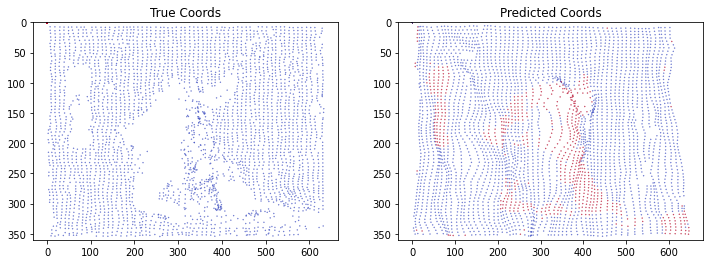

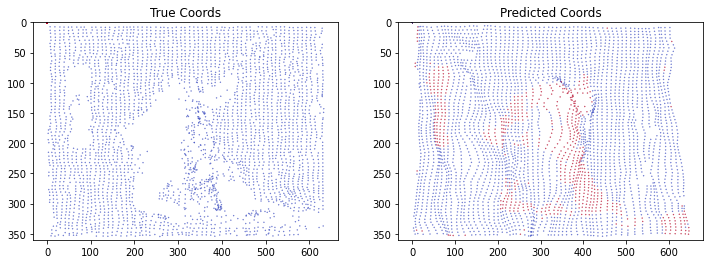

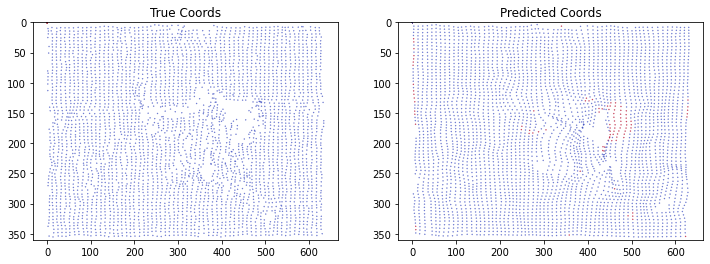

In [120]:
# Set computation device
device = torch.device('cuda')

# MODEL INITIALISATION
# possible params to_learn=[]:
#   'backbone.conv1.weight' - first layer
#   'backbone.layer1.0.conv1.weight' - second layer
#   'classifier.4.weight', 'classifier.4.bias' - last layer
#   'all' - all layers
modified_model = initialise_model(device, to_learn=['all'])
params_to_update = modified_model.parameters()

# print('Params to learn:')
# for name, param in modified_model.named_parameters():
#   if param.requires_grad:
#       print(name)

# DEFINE HYPERPARAMETERS
validation_split = 0.2 # Validation ratio split
shuffle_dataset = True
random_seed = 42
B = 10 # Batch size
E = 1_000 # Number of epoch
C=1.0 # Gradient lip value
eval_freq=100 # Run val mode every 100th epoch
report_freq=500 #Print stats every 500th epoch

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, B, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Define optimizer
LR = 0.101 # learning rate
M = 0.9 # momentum
my_optimizer = optim.SGD(params_to_update, lr=LR, momentum=M)

# Setup the loss
my_criterion = nn.MSELoss()
my_vis_criterion = nn.BCELoss()

# TRAIN
model2, model_t_loss,  model_v_loss  = train_model(modified_model,
                                                  dataloaders_dict,
                                                  my_criterion,
                                                  my_vis_criterion,
                                                  my_optimizer,
                                                  num_epochs=E,
                                                  verbose=True,
                                                  clip=C,
                                                  store_val=False, #store best val or train loss model
                                                  eval_freq=100,
                                                  report_freq=500)

### Save model

In [121]:
# Save checkpoint
checkpoint = {'criterions': [my_criterion, my_vis_criterion],
              'description': 'model trained on 10 samples from 3 videos',
              'epochs': E,
              'train_loss_history': model_t_loss,
              'val_loss_history': model_v_loss,
              'params_to_learn': ["all"],
              'val_split': validation_split,
              'random_seed': random_seed,
              'batch_size': B,
              'optimizer': 'SGD',
              'learning_rate': LR,
              'momentum': M,
              'optimizer': my_optimizer.state_dict(),
              'state_dict': model2.state_dict()}


TODAY = date.today()
torch.save(checkpoint, 'checkpoint2_'+str(TODAY)+'.pth')

# cp checkpoint into drive
!cp checkpoint2_"$TODAY".pth /content/drive/MyDrive/checkpoints/

## Loading checkpoints, plotting results

╒═══════════════════════════════════════════════════╤═════════╤══════════╤══════════╤══════════╤══════════╕
│ model trained on 10 samples from the same video   │     E=0 │   E=1250 │   E=2500 │   E=3750 │   E=5000 │
╞═══════════════════════════════════════════════════╪═════════╪══════════╪══════════╪══════════╪══════════╡
│ train_loss                                        │ 6.09343 │ 0.243788 │ 0.234032 │  0.23044 │ 0.234148 │
├───────────────────────────────────────────────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│ valid_loss                                        │         │          │          │          │          │
╘═══════════════════════════════════════════════════╧═════════╧══════════╧══════════╧══════════╧══════════╛


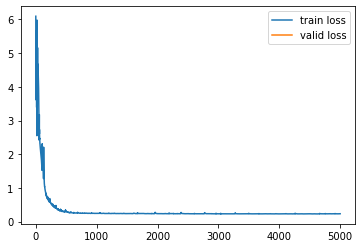

In [133]:
model_weights, random_seed = load_checkpoint("checkpoint12023-02-13.pth")

╒═════════════════════════════════════════════╤═════════╤═════════╤═══════════╤═══════════╤═══════════╕
│ model trained on 10 samples from 3 videos   │     E=0 │   E=250 │     E=500 │     E=750 │    E=1000 │
╞═════════════════════════════════════════════╪═════════╪═════════╪═══════════╪═══════════╪═══════════╡
│ train_loss                                  │ 4.85045 │ 1.47016 │  0.406842 │  0.200165 │  0.138857 │
├─────────────────────────────────────────────┼─────────┼─────────┼───────────┼───────────┼───────────┤
│ valid_loss                                  │ 4.39796 │ 8.77535 │ 10.5326   │ 11.7258   │ 13.0719   │
╘═════════════════════════════════════════════╧═════════╧═════════╧═══════════╧═══════════╧═══════════╛


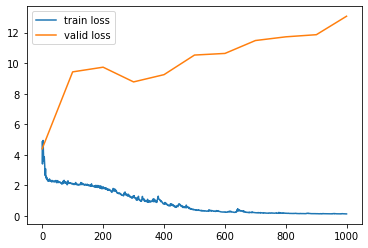

In [134]:
model_weights2, random_seed = load_checkpoint("checkpoint2_2023-02-14.pth")

## Evaluation
Showing some predictions from the second model on unseen samples




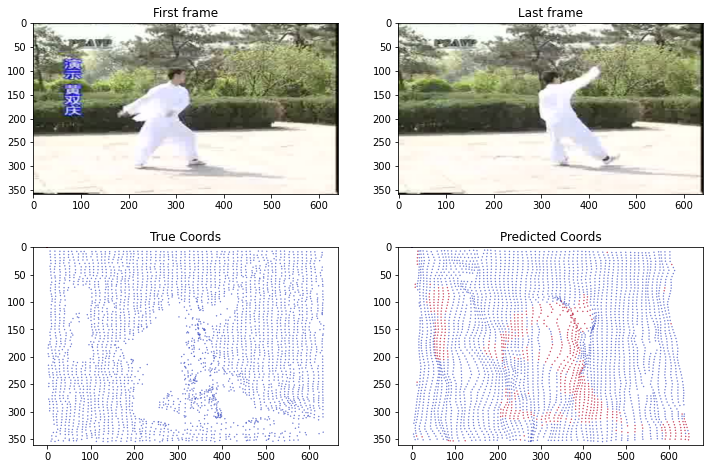

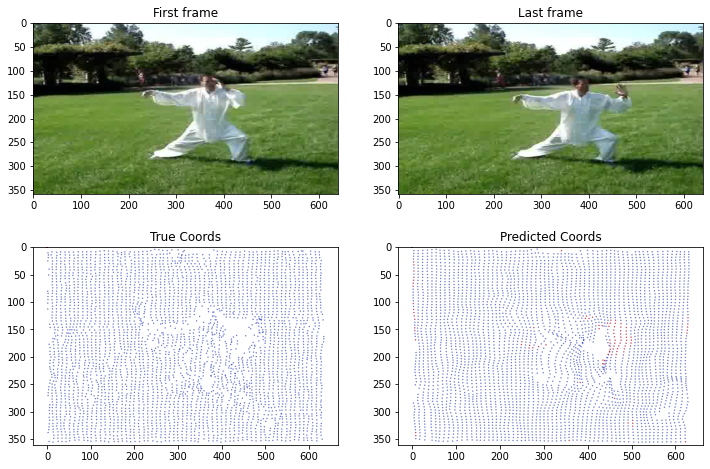

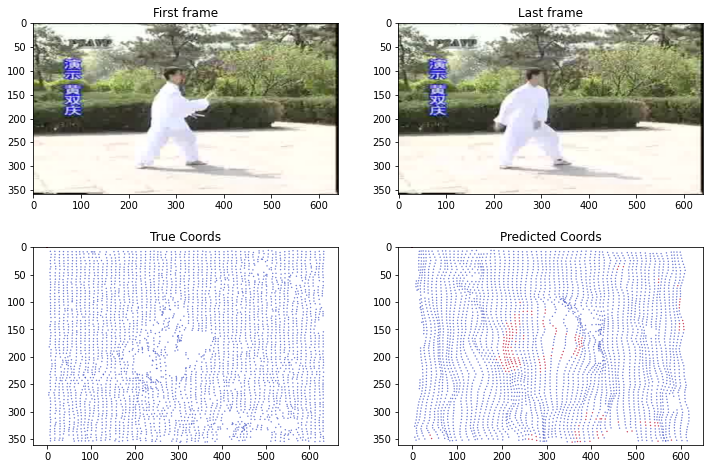

Valid Loss: 13.0719 (9.2173 coords loss, 3.8546 vis loss) 
Average valid Loss: 13.0719 (9.2173 coords loss, 3.8546 vis loss) 


In [128]:
# Set computation device
device = torch.device('cuda')

# MODEL INITIALISATION
model = initialise_model(device, to_learn=['all'])
model.load_state_dict(model_weights2)


# DEFINE HYPERPARAMETERS
validation_split = 0.2 # Validation ratio split
shuffle_dataset = True
random_seed = 42
B = 10 # Batch size

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, B, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Setup the loss
my_criterion = nn.MSELoss()
my_vis_criterion = nn.BCELoss()

# EVALUATE
evaluate_model(model, dataloaders_dict['val'], my_criterion, my_vis_criterion)